# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

In [1]:
!pip install transformers

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [3]:
!mkdir data
!curl https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1 -o data/arguments-training.tsv
!curl https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1 -o data/arguments-validation.tsv
!curl https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1 -o data/arguments-test.tsv
!curl https://zenodo.org/records/8248658/files/labels-training.tsv?download=1 -o data/labels-training.tsv
!curl https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1 -o data/labels-validation.tsv
!curl https://zenodo.org/records/8248658/files/labels-test.tsv?download=1 -o data/labels-test.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  988k  100  988k    0     0   403k      0  0:00:02  0:00:02 --:--:--  403k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  354k  100  354k    0     0   225k      0  0:00:01  0:00:01 --:--:--  225k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  283k  100  283k    0     0   173k      0  0:00:01  0:00:01 --:--:--  173k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   159k      0  0:00:01  0:00:01 --:--:--  159k
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
arguments_train = pd.read_csv('data/arguments-training.tsv', sep='\t')
arguments_val = pd.read_csv('data/arguments-validation.tsv', sep='\t')
arguments_test = pd.read_csv('data/arguments-test.tsv', sep='\t')
labels_train = pd.read_csv('data/labels-training.tsv', sep='\t')
labels_val = pd.read_csv('data/labels-validation.tsv', sep='\t')
labels_test = pd.read_csv('data/labels-test.tsv', sep='\t')

In [5]:
OPEN = 'Openness to change'
ENHANCE = 'Self-enhancement'
CONSERVE = 'Conservation'
TRANSCEND = 'Self-transcendence'

TOUCHE_VALUES = [OPEN, ENHANCE, CONSERVE, TRANSCEND]

value_mapping = {
    'Self-direction: thought' : [OPEN],
    'Self-direction: action' : [OPEN],
    'Stimulation' : [OPEN],
    'Hedonism' : [OPEN, ENHANCE],
    'Achievement' : [ENHANCE],
    'Power: dominance' : [ENHANCE],
    'Power: resources' : [ENHANCE],
    'Face' : [CONSERVE, ENHANCE],
    'Security: personal' : [CONSERVE],
    'Security: societal' : [CONSERVE],
    'Tradition' : [CONSERVE],
    'Conformity: rules' : [CONSERVE],
    'Conformity: interpersonal' : [CONSERVE],
    'Humility' : [TRANSCEND, CONSERVE],
    'Benevolence: caring' : [TRANSCEND],
    'Benevolence: dependability' : [TRANSCEND],
    'Universalism: concern' : [TRANSCEND],
    'Universalism: nature' : [TRANSCEND],
    'Universalism: tolerance' : [TRANSCEND],
    'Universalism: objectivity' : [TRANSCEND]
}

In [6]:
def build_dataset(arguments, labels):
    """
        Building the dataset merging leve 2 categories into level 3
    """
    new_dataset = []
    for argument_element, label_element in zip(arguments.iloc, labels.iloc):
        assert argument_element['Argument ID'] == label_element['Argument ID']
        new_element = { k : 0 for k in TOUCHE_VALUES }
        for level_2_value, level_3_values in value_mapping.items():
            if label_element[level_2_value] == 1:
                for level_3_value in level_3_values:
                    new_element[level_3_value] = 1

        for k in ['Premise', 'Stance', 'Conclusion']:
            new_element[k] = argument_element[k]
        new_dataset.append(new_element)

    return pd.DataFrame(new_dataset)

train_df = build_dataset(arguments_train, labels_train)
val_df = build_dataset(arguments_val, labels_val)
test_df = build_dataset(arguments_test, labels_test)

In [7]:
class ValueDataset(torch.utils.data.Dataset):
    """
        Class used to convert dataframe into a dataset
    """
    def __init__(self, df):
        self.premises = list(df['Premise'].values)
        self.stances = torch.Tensor([
            [1, 0] if x['Stance'].lower() == 'in favor of' else [0, 1]
            for x in df.iloc
        ])
        self.conclusions = list(df['Conclusion'].values)
        self.labels = torch.stack([
            torch.Tensor(df[k].values)
            for k in TOUCHE_VALUES
        ], axis=-1)

    def __len__(self):
        return len(self.stances)

    def __getitem__(self, idx):
        return (self.premises[idx], self.conclusions[idx], self.stances[idx], self.labels[idx])

In [8]:
train_dataset = ValueDataset(train_df)
val_dataset = ValueDataset(val_df)
test_dataset = ValueDataset(test_df)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

In [10]:
class RandomUniformClassifier(nn.Module):
    """
        Random Uniform Classifier as first Baseline
    """
    def __init__(self, output_shape, device='cuda'):
        super().__init__()
        self.output_shape = output_shape
        self.device = device

    def forward(self, x, *args, **kwargs):
        return torch.rand((len(x),) + self.output_shape, device=self.device)

In [11]:
class FixedOutputClassifier(nn.Module):
    """
        Majority Classifier as second Baseline
    """
    def __init__(self, output, device):
        super().__init__()
        self.output = output.to(device)

    def forward(self, x, *args, **kwargs):
        return self.output.unsqueeze(dim=0).repeat(len(x), 1)

def build_majority_classifier(dataloader, device):
    """
        Helper function to build the Majority Classifier
        most common output should be [0,0,1,1]
    """
    count = 0
    total_length = 0

    for _, _, _, labels in dataloader:
        # labels is [B, 4]
        count += labels.sum(axis=0)
        total_length += len(labels)

    most_common_output = (count >= total_length / 2).long()
    return FixedOutputClassifier(most_common_output, device)

In [12]:
class BERTC(nn.Module):
    """
        BERT Classifier with only the conclusion
    """
    def __init__(self, tokenizer, base_model, device='cuda'):
        super().__init__()
        self.tokenizer = tokenizer
        self.base_model = base_model
        self.device = device

    def encode(self, text):
        encoded_inputs = self.tokenizer(text, return_tensors='pt', padding=True).to(self.device)
        attention_mask = encoded_inputs['attention_mask'].unsqueeze(-1)

    def forward(self, premise, conclusion, stance):
        encoded = self.tokenizer(
            conclusion,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        output = self.base_model(**encoded)
        return output.logits

In [13]:
class BERTCP(BERTC):
    """
        BERT Classifier with Conclusion and Premise
    """
    def forward(self, premise, conclusion, stance):
        encoded = self.tokenizer(
            premise,
            conclusion,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        output = self.base_model(**encoded).logits
        return output

In [14]:
class BERTCPS(BERTC):
    """
        BERT Classifier with Conclusion, Premise and Stance
    """
    def forward(self, premise, conclusion, stance):
        encoded = self.tokenizer(
            premise,
            conclusion,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        output = self.base_model(**encoded).logits
        return output

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [15]:
def evaluate(model, loader, verbose=True):
    """
        Evaluate the model on the given loader
    """
    model.eval()
    loss = 0
    all_outputs = []
    all_labels = []
    f1s = []
    for premise, conclusion, stance, label in loader:
        with torch.no_grad():
            label = label.to(device)
            output = model(premise, conclusion, stance)
            loss += BCEWithLogitsLoss()(output.float(), label.float()).item()
            output = torch.sigmoid(output)  # Apply sigmoid activation
            all_outputs.append(output.cpu().numpy())
            all_labels.append(label.cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    standard_threshold = 0.5
    for i, value_name in enumerate(TOUCHE_VALUES):
        f1 = f1_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)
        f1s.append(f1)
        precision = precision_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)
        recall = recall_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)

    macro_f1 = np.mean(f1s)

    if verbose:
        print(f'Loss: {loss / len(loader)}')
        print(f'F1: {macro_f1}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')

    return f1s, macro_f1, all_outputs, all_labels

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [16]:
class BestModel:
    """
        Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = model.state_dict()


bce_loss = nn.BCEWithLogitsLoss(reduction='sum')

class MulticlassBCE:
    """
        Class used to compute Multi Label BCE
    """
    def __init__(self, num_labels):
        self.num_labels = num_labels

    def __call__(self, outputs, labels):
        loss = 0

        for i in range(self.num_labels):
            loss += bce_loss(outputs[:, i], labels[:, i])

        return loss / self.num_labels

loss_function = MulticlassBCE(num_labels=4)

def train(model, train_loader, val_loader, loss_function, epochs, lr, weight_decay, lr_decay_factor, lr_decay_patience, verbose=False):
    """
        Train loop with the specified parameters
    """
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()

    try:
        for i in range(epochs):
            model.train()
            for premises, conclusions, stances, labels in tqdm(train_loader, desc=f'Epoch {i + 1}/{epochs}'):
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(premises, conclusions, stances)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                for premises, conclusions, stances, labels in val_loader:
                    labels = labels.to(device)
                    outputs = model(premises, conclusions, stances)
                    loss = loss_function(outputs, labels)
                    total_val_loss += loss.cpu().item()
            best_model_tracker(model, total_val_loss)
            if verbose:
                print(f'Validation Loss: {total_val_loss / len(val_loader):.3f}')
            # scheduler.step(total_val_loss) #TODO: to remove?
    except KeyboardInterrupt:
        pass

    model.load_state_dict(best_model_tracker.best_state_dict)

    return best_model_tracker

In [17]:
seeds = [42, 69, 420]

results = {
    'random' : [],
    'majority' : [],
    'bertc' : [],
    'bertcp' : [],
    'bertcps' : []
}

EPOCHS = 10
INITIAL_LR = 0.01
WEIGHT_DECAY = 0.01
LR_DECAY_FACTOR = 0.1
LR_DECAY_PATIENCE = 2
HIDDEN_SIZE = 100
DROPOUT = 0.2
TRAIN_BERT = False

for seed in seeds[:1]:
    print(f'{f"TRAINING WITH SEED {seed}":=^65}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased');
    bertc_base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4);
    bertc_base_model.base_model.requires_grad_(TRAIN_BERT);
    bertc_base_model.to(device);

    bertcp_base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4);
    bertcp_base_model.base_model.requires_grad_(TRAIN_BERT);
    bertcp_base_model.to(device);

    bertcps_base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4);
    bertcps_base_model.base_model.requires_grad_(TRAIN_BERT);
    bertcps_base_model.to(device);

    models = {
        'random' : RandomUniformClassifier((4,), device=device),
        'majority' : build_majority_classifier(train_dataloader, device=device),
        'bertc' : BERTC(tokenizer, bertc_base_model, device=device),
        'bertcp' : BERTCP(tokenizer, bertcp_base_model, device=device),
        'bertcps' : BERTCPS(tokenizer, bertcps_base_model, device=device)
    }

    for model_name, model in models.items():
        f1s = []
        macro_f1 = None
        all_outputs = []
        all_labels = []
        print(f'{f"Training model {model_name}":_^65}')
        torch.manual_seed(seed)
        np.random.seed(seed)

        if model_name.startswith('bert'):
            _ = train(model, train_dataloader, val_dataloader, loss_function, EPOCHS, INITIAL_LR, WEIGHT_DECAY, LR_DECAY_FACTOR, LR_DECAY_PATIENCE, verbose=True)
        f1s, macro_f1, all_outputs, all_labels = evaluate(model, test_dataloader, verbose=False)
        print(f'Model: {model_name} - F1: {[round(x,3) for x in f1s]    } - macro: {macro_f1:.3f}')
        print('\n\n')
        results[model_name].append({
            'f1s' : np.array(f1s),
            'macro_f1' : macro_f1,
            'all_outputs': all_outputs,
            'all_labels': all_labels
        })

for model_name, model_results in results.items():
    all_f1s = []
    macro_f1s = []
    for model_result in model_results:
        all_f1s.append(model_result['f1s'])
        macro_f1s.append(model_result['macro_f1'])

    print(f'{model_name}:')
    all_f1s = np.array(all_f1s)
    for i, value_name in enumerate(TOUCHE_VALUES):
        print(f'{value_name} F1: {all_f1s[:, i].mean():.3f}')
    print(f'Macro F1: {np.mean(macro_f1s):.3f}')
    print()

======================TRAINING WITH SEED 42======================



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


______________________Training model random______________________
Model: random - F1: [0.462, 0.582, 0.83, 0.892] - macro: 0.692



_____________________Training model majority_____________________
Model: majority - F1: [0.462, 0.582, 0.83, 0.892] - macro: 0.692



______________________Training model bertc_______________________


Epoch 1/10: 100%|██████████| 169/169 [00:09<00:00, 17.54it/s]


Validation Loss: 20.864


Epoch 2/10: 100%|██████████| 169/169 [00:07<00:00, 23.18it/s]


Validation Loss: 20.456


Epoch 3/10: 100%|██████████| 169/169 [00:06<00:00, 24.20it/s]


Validation Loss: 26.838


Epoch 4/10: 100%|██████████| 169/169 [00:07<00:00, 22.82it/s]


Validation Loss: 19.499


Epoch 5/10: 100%|██████████| 169/169 [00:07<00:00, 22.77it/s]


Validation Loss: 22.812


Epoch 6/10: 100%|██████████| 169/169 [00:07<00:00, 23.09it/s]


Validation Loss: 22.820


Epoch 7/10: 100%|██████████| 169/169 [00:08<00:00, 19.24it/s]


Validation Loss: 22.414


Epoch 8/10: 100%|██████████| 169/169 [00:07<00:00, 21.81it/s]


Validation Loss: 21.771


Epoch 9/10: 100%|██████████| 169/169 [00:07<00:00, 22.64it/s]


Validation Loss: 21.176


Epoch 10/10: 100%|██████████| 169/169 [00:07<00:00, 22.31it/s]


Validation Loss: 20.819
Model: bertc - F1: [0.181, 0.386, 0.689, 0.892] - macro: 0.537



______________________Training model bertcp______________________


Epoch 1/10: 100%|██████████| 169/169 [00:33<00:00,  4.98it/s]


Validation Loss: 26.205


Epoch 2/10: 100%|██████████| 169/169 [00:32<00:00,  5.13it/s]


Validation Loss: 24.937


Epoch 3/10: 100%|██████████| 169/169 [00:33<00:00,  5.03it/s]


Validation Loss: 21.657


Epoch 4/10: 100%|██████████| 169/169 [00:33<00:00,  5.12it/s]


Validation Loss: 21.089


Epoch 5/10: 100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


Validation Loss: 22.933


Epoch 6/10: 100%|██████████| 169/169 [00:36<00:00,  4.59it/s]


Validation Loss: 20.401


Epoch 7/10: 100%|██████████| 169/169 [00:41<00:00,  4.11it/s]


Validation Loss: 23.004


Epoch 8/10: 100%|██████████| 169/169 [00:36<00:00,  4.67it/s]


Validation Loss: 24.088


Epoch 9/10: 100%|██████████| 169/169 [00:33<00:00,  5.03it/s]


Validation Loss: 20.797


Epoch 10/10: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


Validation Loss: 20.202
Model: bertcp - F1: [0.016, 0.003, 0.83, 0.892] - macro: 0.435



_____________________Training model bertcps______________________


Epoch 1/10: 100%|██████████| 169/169 [00:33<00:00,  5.06it/s]


Validation Loss: 25.492


Epoch 2/10: 100%|██████████| 169/169 [00:34<00:00,  4.88it/s]


Validation Loss: 25.249


Epoch 3/10: 100%|██████████| 169/169 [00:33<00:00,  5.06it/s]


Validation Loss: 21.224


Epoch 4/10: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s]


Validation Loss: 21.395


Epoch 5/10: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s]


Validation Loss: 23.497


Epoch 6/10: 100%|██████████| 169/169 [00:33<00:00,  5.01it/s]


Validation Loss: 20.300


Epoch 7/10: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s]


Validation Loss: 22.977


Epoch 8/10: 100%|██████████| 169/169 [00:33<00:00,  5.07it/s]


Validation Loss: 24.011


Epoch 9/10: 100%|██████████| 169/169 [00:34<00:00,  4.96it/s]


Validation Loss: 20.753


Epoch 10/10: 100%|██████████| 169/169 [00:32<00:00,  5.12it/s]


Validation Loss: 20.087
Model: bertcps - F1: [0.02, 0.003, 0.83, 0.892] - macro: 0.436



random:
Openness to change F1: 0.462
Self-enhancement F1: 0.582
Conservation F1: 0.830
Self-transcendence F1: 0.892
Macro F1: 0.692

majority:
Openness to change F1: 0.462
Self-enhancement F1: 0.582
Conservation F1: 0.830
Self-transcendence F1: 0.892
Macro F1: 0.692

bertc:
Openness to change F1: 0.181
Self-enhancement F1: 0.386
Conservation F1: 0.689
Self-transcendence F1: 0.892
Macro F1: 0.537

bertcp:
Openness to change F1: 0.016
Self-enhancement F1: 0.003
Conservation F1: 0.830
Self-transcendence F1: 0.892
Macro F1: 0.435

bertcps:
Openness to change F1: 0.020
Self-enhancement F1: 0.003
Conservation F1: 0.830
Self-transcendence F1: 0.892
Macro F1: 0.436



# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

In [18]:
for model_name in models.keys():
    for res in results[model_name]:
        print(res['f1s'])

[0.46243902 0.58209627 0.83042672 0.89170183]
[0.46243902 0.58209627 0.83042672 0.89170183]
[0.1810219  0.38554217 0.6886121  0.89170183]
[0.01649485 0.00306279 0.82955811 0.89162562]
[0.0204499  0.00306279 0.82955811 0.89162562]


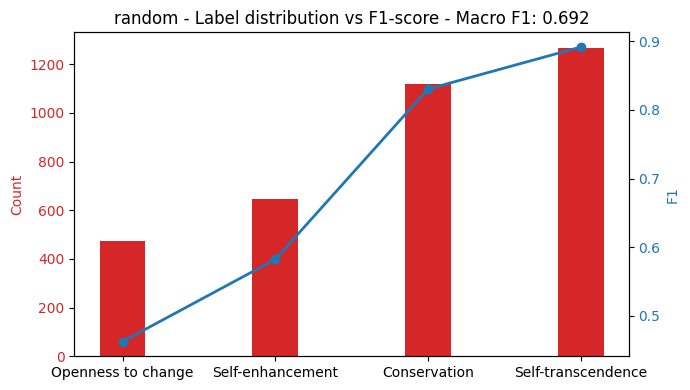

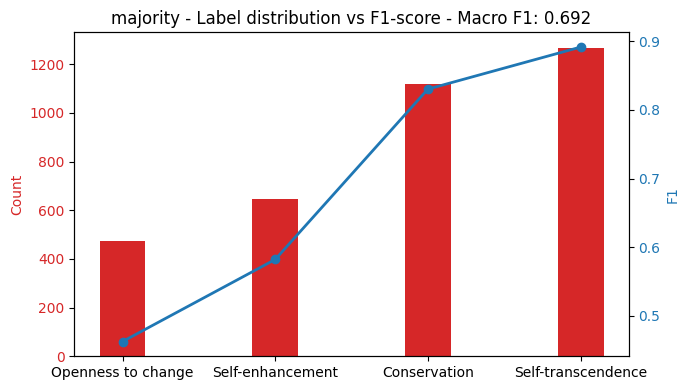

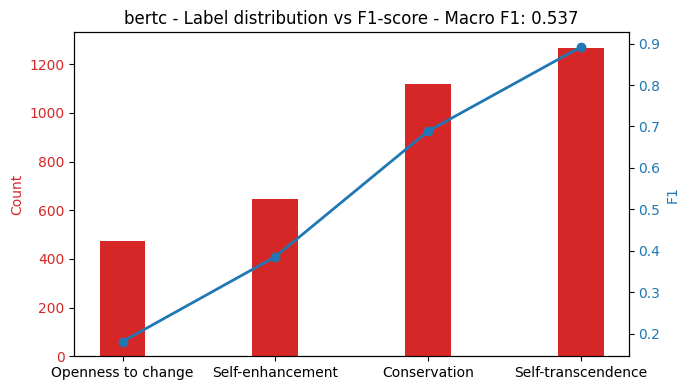

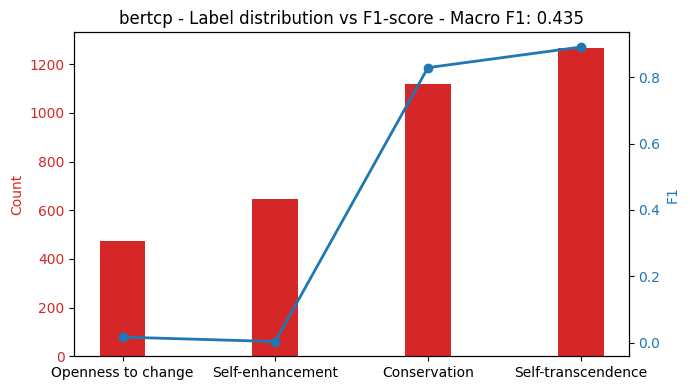

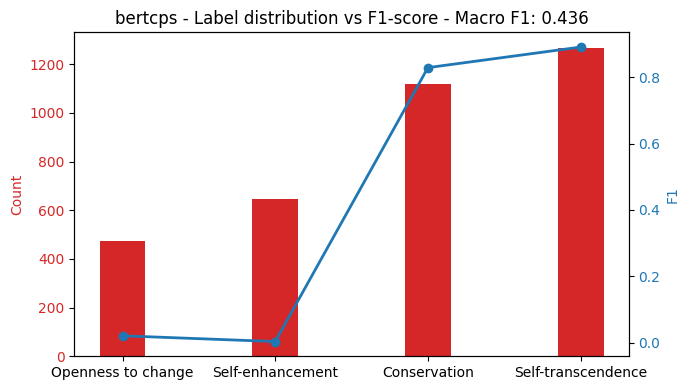

In [19]:
labels_count = test_dataset.labels.sum(axis=0)

for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.set_title(f'{model_name} - Label distribution vs F1-score - Macro F1: {model_results_best["macro_f1"]:.3f}')
    color = 'tab:red'
    ax1.bar(TOUCHE_VALUES, labels_count, color=color, width=0.3)
    ax1.set_xticklabels(TOUCHE_VALUES, rotation=0)
    ax1.set_ylabel('Count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.plot(TOUCHE_VALUES, model_results_best['f1s'], color=color, linewidth=2, marker='o')
    ax2.set_ylabel('F1', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.show()


In [20]:
for model_name in list(results.keys()):
    print(f'{f"Comparison for model: {model_name}":_^65}')
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    model_summary = pd.DataFrame(index=TOUCHE_VALUES, columns=['Precision', 'Recall', 'F1'])
    for i, value_name in enumerate(TOUCHE_VALUES):
        model_summary.loc[value_name] = [
            round(precision_score(test_dataset.labels[:, i], model_results_best['all_outputs'][:, i] >= 0.5), 3),
            round(recall_score(test_dataset.labels[:, i], model_results_best['all_outputs'][:, i] >= 0.5), 3),
            round(model_results_best['f1s'][i],3)
        ]
    print(model_summary.head())
    print()

__________________Comparison for model: random___________________
                   Precision Recall     F1
Openness to change     0.301    1.0  0.462
Self-enhancement       0.411    1.0  0.582
Conservation            0.71    1.0   0.83
Self-transcendence     0.805    1.0  0.892

_________________Comparison for model: majority__________________
                   Precision Recall     F1
Openness to change     0.301    1.0  0.462
Self-enhancement       0.411    1.0  0.582
Conservation            0.71    1.0   0.83
Self-transcendence     0.805    1.0  0.892

___________________Comparison for model: bertc___________________
                   Precision Recall     F1
Openness to change     0.294  0.131  0.181
Self-enhancement       0.481  0.321  0.386
Conservation           0.686  0.692  0.689
Self-transcendence     0.805    1.0  0.892

__________________Comparison for model: bertcp___________________
                   Precision Recall     F1
Openness to change     0.364  0.008  0.016
Se

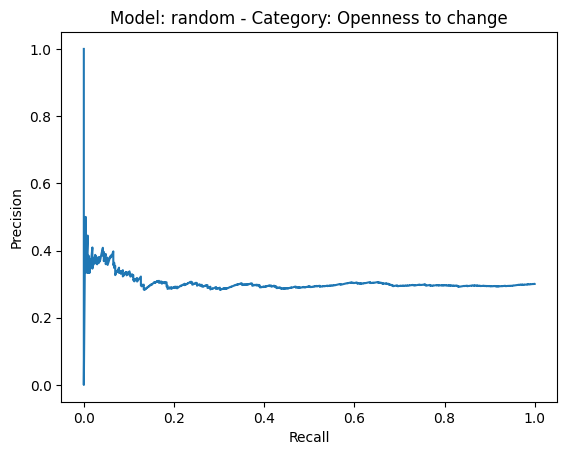

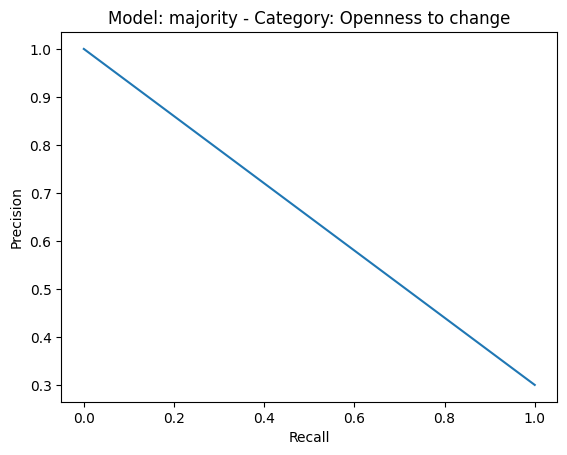

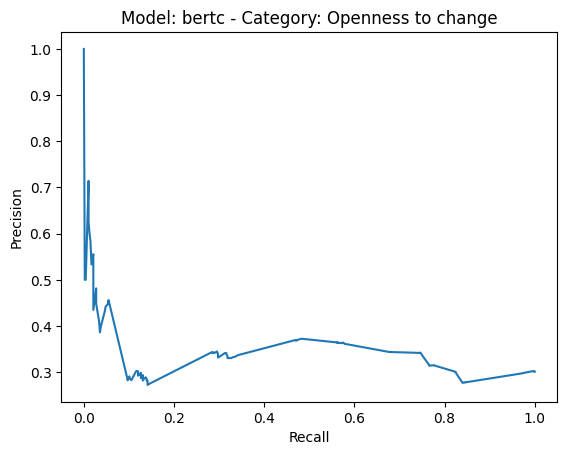

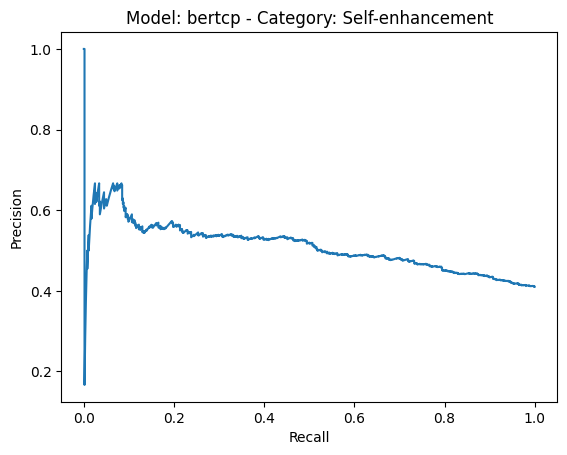

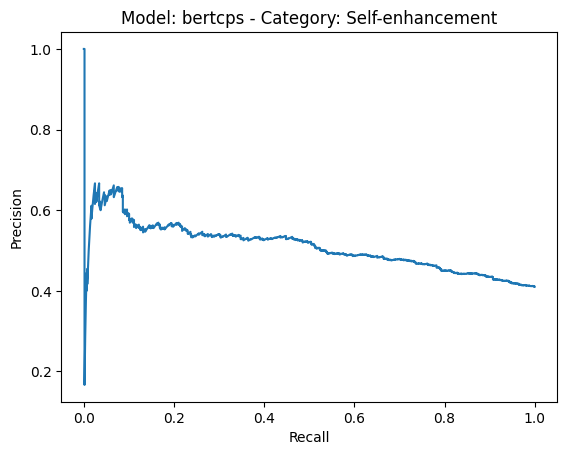

In [21]:
# computing precision-recall curve for each model on category with the lowest f1-score
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    most_misclassified_category_index = np.argmin(model_results_best['f1s'])
    most_misclassified_category = TOUCHE_VALUES[most_misclassified_category_index]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'][:, most_misclassified_category_index], model_results_best['all_outputs'][:, most_misclassified_category_index])
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Model: {model_name} - Category: {most_misclassified_category}')
    plt.show()

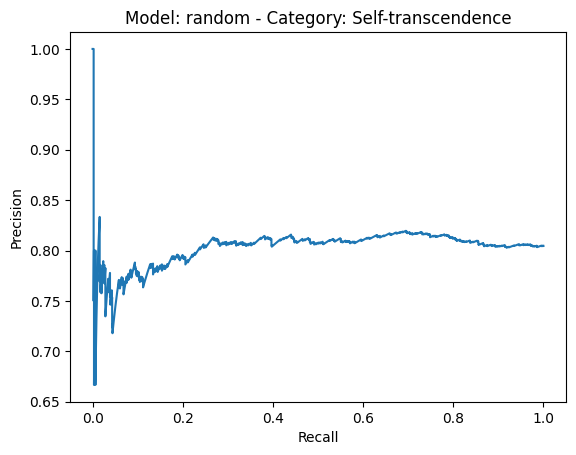

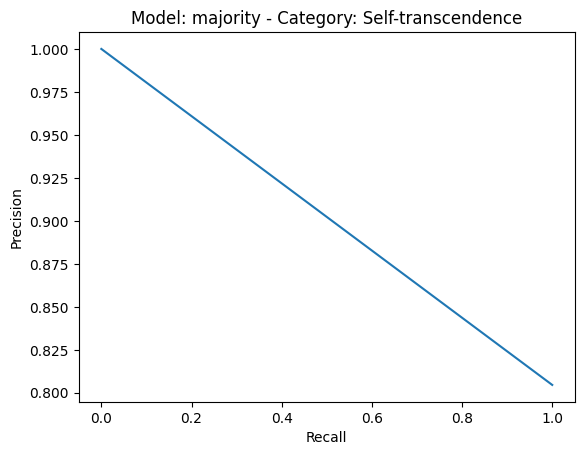

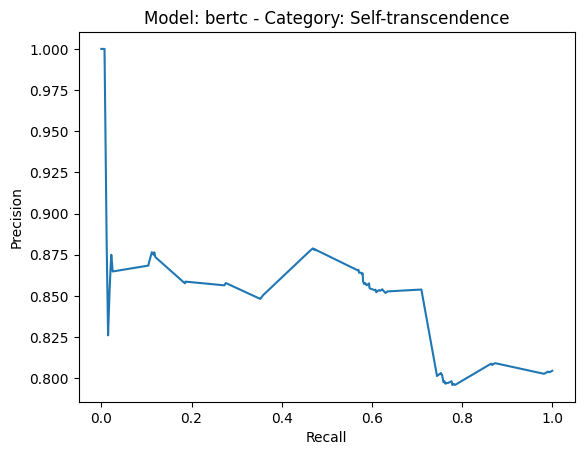

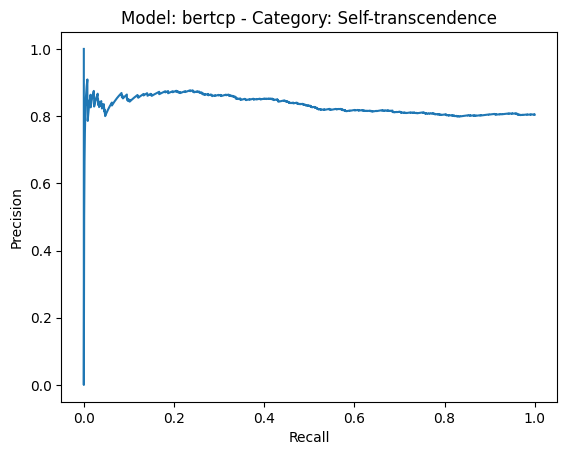

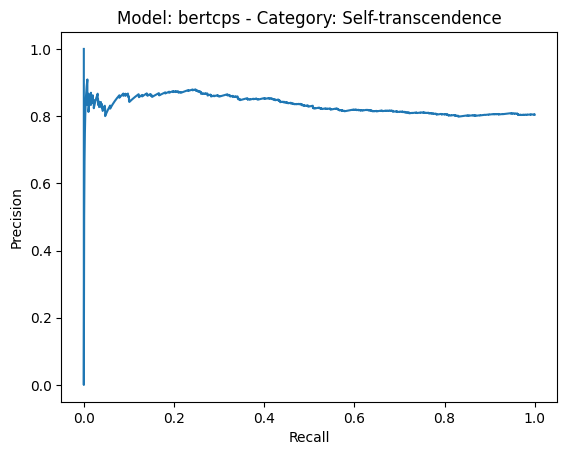

In [22]:
# computing precision-recall curve for each model on category with the highest f1-score
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    most_classified_category_index = np.argmax(model_results_best['f1s'])
    most_classified_category = TOUCHE_VALUES[most_classified_category_index]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'][:, most_classified_category_index], model_results_best['all_outputs'][:, most_classified_category_index])
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Model: {model_name} - Category: {most_classified_category}')
    plt.show()

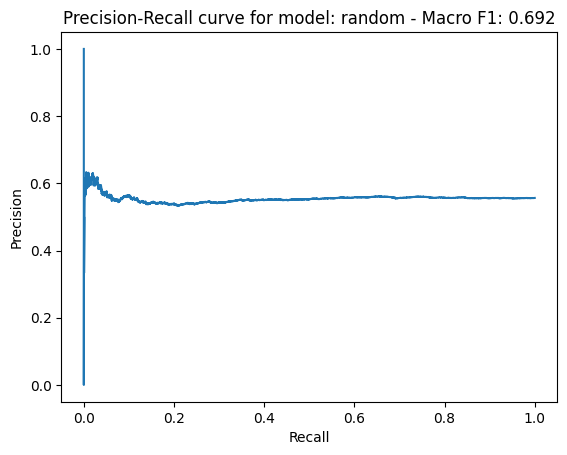

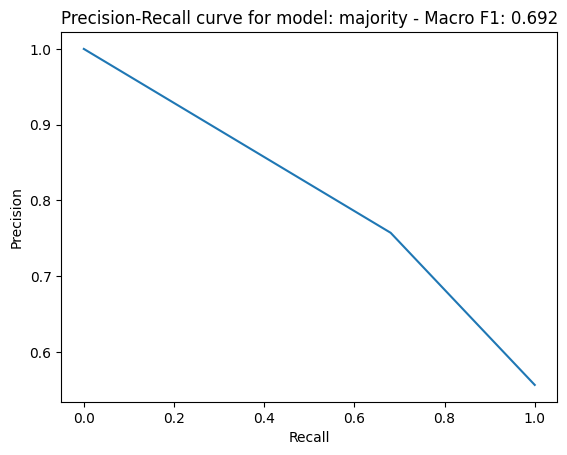

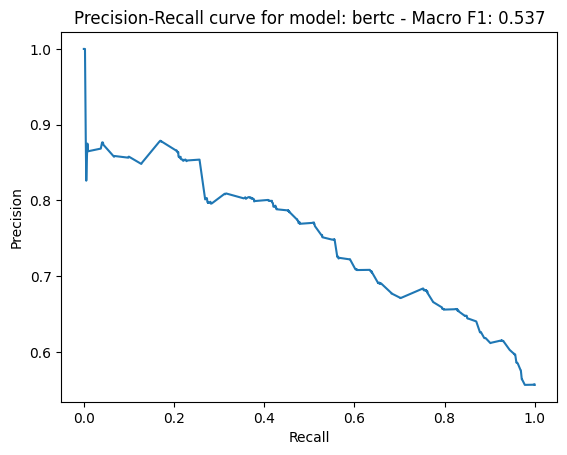

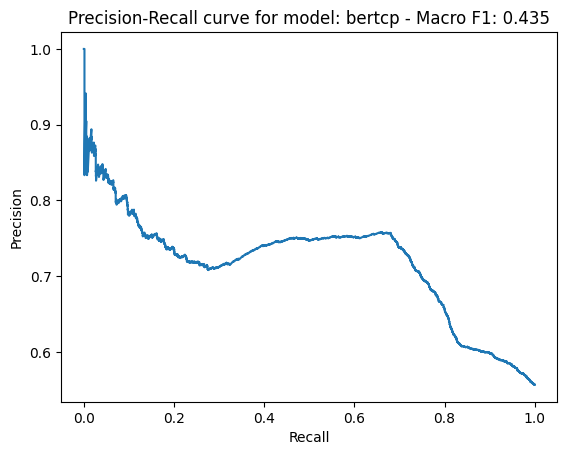

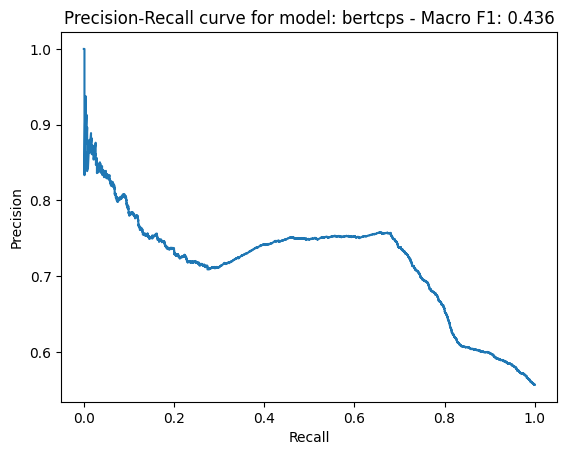

In [23]:
# computing precision-recall curve for each model on the macro f1 score
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'].flatten(), model_results_best['all_outputs'].flatten())
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for model: {model_name} - Macro F1: {model_results_best["macro_f1"]:.3f}')
    plt.show()

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End